Found 10400 files belonging to 13 classes.
Found 2600 files belonging to 13 classes.
Epoch 1/30


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.2092 - loss: 2.3733 - val_accuracy: 0.4965 - val_loss: 1.6082
Epoch 2/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.5482 - loss: 1.4236 - val_accuracy: 0.6435 - val_loss: 1.1544
Epoch 3/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.6948 - loss: 1.0137 - val_accuracy: 0.7285 - val_loss: 0.9010
Epoch 4/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.7749 - loss: 0.7809 - val_accuracy: 0.7885 - val_loss: 0.7353
Epoch 5/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.8244 - loss: 0.6404 - val_accuracy: 0.8158 - val_loss: 0.6250
Epoch 6/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.8594 - loss: 0.5074 - val_accuracy: 0.8485 - val_loss: 0.5451
Epoch 7/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.8881 - loss: 0.4285 - val_accuracy: 0.8631 - val_loss: 0.4809
Epoch 8/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9072 - loss: 0.3499 - val_accurac

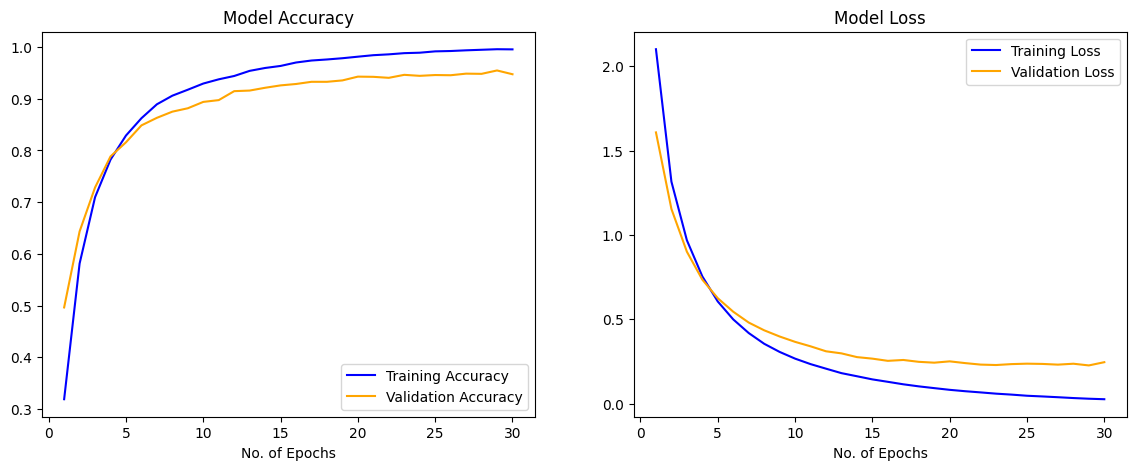

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
Confusion Matrix:
[[200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 199   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0]
 [  1   3   4   2   0   0   4   0 170  10   3   1   2]
 [  5   3   2   2   0   1   2   0  21 140  10   2  12]
 [  0   0   0   0   0   2   5   0   7   6 175   1   4]
 [  0   0   0   0   0   0   0   0   3   0   0 197   0]
 [  3   0   2   0   0   0   1   1   1   3   6   1 182]]
                                                        precision    recall  f1-score   support

               Potato Pest__Agrotis ipsilon (Hufnagel)       0.96      1.00      0.98       200
              Potato Pest__Amras

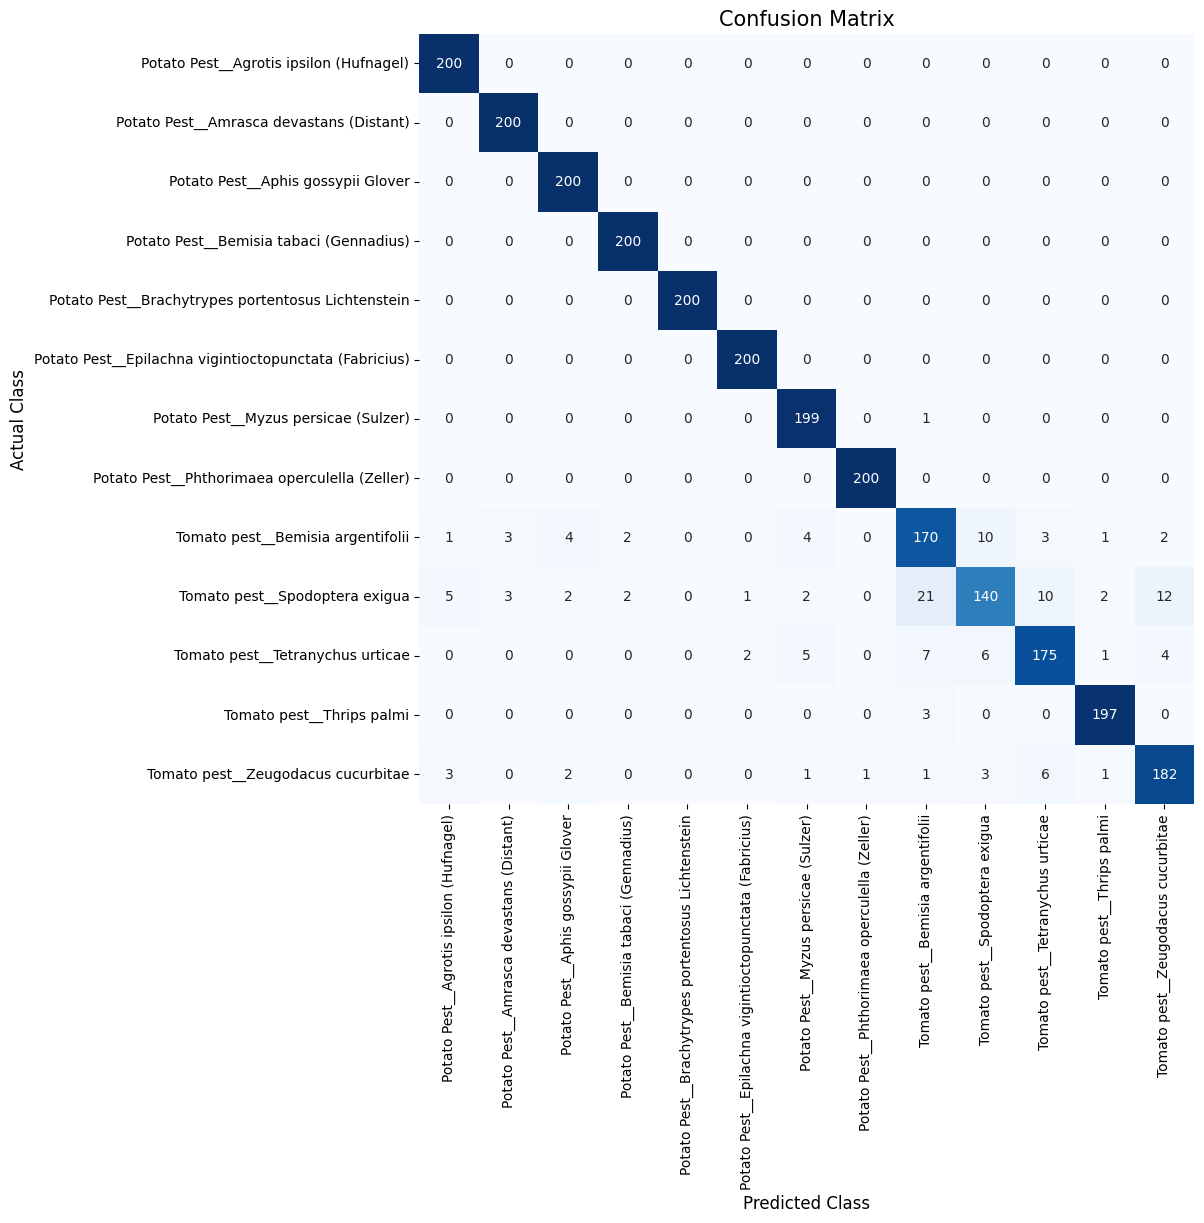

['scaler_model.pkl']

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load training and validation datasets
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="int",  # Use integer labels for the neural network
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

# Load pre-trained model for feature extraction
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Extract features from dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(feature_extractor(images).numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(training_set)
X_val, y_val = extract_features(validation_set)

# Dimensionality reduction
pca = PCA(n_components=50)  # Choose the number of components based on experimentation
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

# Define a shallow neural network model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(50,)),  # Input shape after PCA
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(len(training_set.class_names), activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_val_scaled, y_val), batch_size=32)

# Plot training and validation accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Model Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], color='blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Model Loss')
plt.legend()

plt.show()

# Predict and evaluate
y_pred = np.argmax(model.predict(X_val_scaled), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)

# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the trained shallow neural network model
model.save('trained_pest_snn_detection_model.h5')

# Save PCA and scaler
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler_model.pkl')


Found 10400 files belonging to 13 classes.
Found 2600 files belonging to 13 classes.
Epoch 1/30


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.2053 - loss: 2.3905 - val_accuracy: 0.4773 - val_loss: 1.6282
Epoch 2/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.5445 - loss: 1.4536 - val_accuracy: 0.6435 - val_loss: 1.1692
Epoch 3/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.6943 - loss: 1.0326 - val_accuracy: 0.7196 - val_loss: 0.9193
Epoch 4/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.7682 - loss: 0.7964 - val_accuracy: 0.7681 - val_loss: 0.7617
Epoch 5/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8149 - loss: 0.6405 - val_accuracy: 0.8092 - val_loss: 0.6400
Epoch 6/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.8499 - loss: 0.5256 - val_accuracy: 0.8338 - val_loss: 0.5603
Epoch 7/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.8755 - loss: 0.4451 - val_accuracy: 0.8527 - val_loss: 0.5006
Epoch 8/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.9027 - loss: 0.3603 - val_accurac

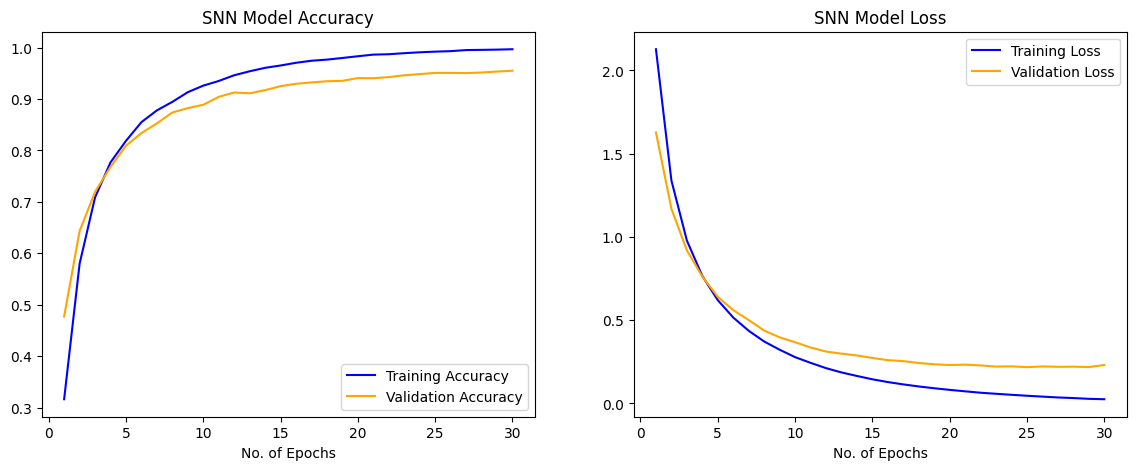

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Confusion Matrix:
[[196   0   0   0   0   3   0   0   1   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 199   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0]
 [  1   3   0   4   0   1   1   1 169  11   6   1   2]
 [  0   4   1   1   0   1   1   0  10 160   9   7   6]
 [  0   1   1   2   2   1   3   0   3   6 174   2   5]
 [  0   0   0   0   0   0   0   0   0   4   0 196   0]
 [  1   0   0   1   0   0   0   1   0   3   4   1 189]]
                                                        precision    recall  f1-score   support

               Potato Pest__Agrotis ipsilon (Hufnagel)       0.99      0.98      0.98       200
              Potato Pest__Amras

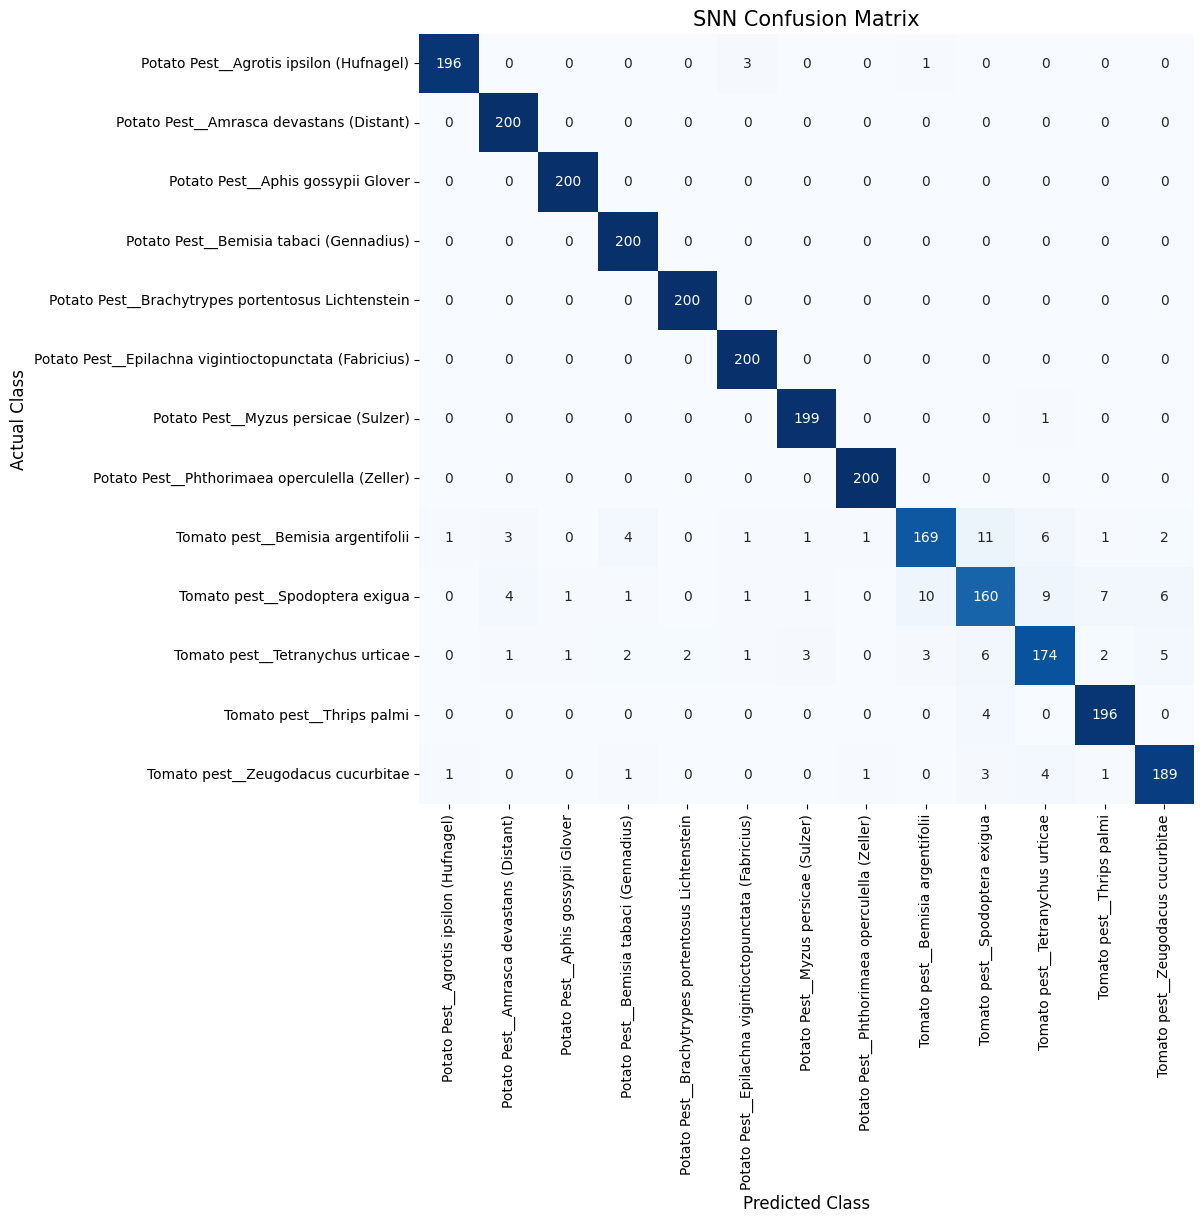

['scaler_model.pkl']

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load training and validation datasets
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="int",  # Use integer labels for the neural network
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

# Load pre-trained model for feature extraction
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Extract features from dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(feature_extractor(images).numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(training_set)
X_val, y_val = extract_features(validation_set)

# Dimensionality reduction
pca = PCA(n_components=50)  # Choose the number of components based on experimentation
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

# Define a shallow neural network model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(50,)),  # Input shape after PCA
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(len(training_set.class_names), activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_val_scaled, y_val), batch_size=32)

# Plot training and validation accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('SNN Model Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], color='blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('SNN Model Loss')
plt.legend()

plt.show()

# Predict and evaluate
y_pred = np.argmax(model.predict(X_val_scaled), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)

# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('SNN Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the trained shallow neural network model
model.save('trained_pest_snn_detection_model.h5')

# Save PCA and scaler
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler_model.pkl')